# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [ ]:
import pandas as pd
import os
import numpy as np

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
**Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.**

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [74]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [75]:
from IPython.core.display import HTML
HTML(filename='/home/thomas/Documents/ADA2017-Tutorials/02 - Intro to Pandas/Data/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

### Question 1

We define the types of the attributes we will use in this task and then load the dataset in titanic.xls

In [76]:
columns_types = {
    'pclass': np.uint8,
    'survived': np.bool_,
    'parch': np.uint8,
    'sibsp': np.uint8,
    'age': np.float32,
    'fare': np.float32,
}

titanic = pd.read_excel('/home/thomas/Documents/ADA2017-Tutorials/02 - Intro to Pandas/Data/titanic.xls',
                        dtype=columns_types)

We transform the attributes pclass, sex and embarked into Categorical. It makes sense to do it with those attributes as the range of values is not very large and it will be useful in the future to display the bar plots.

We then rename the categories to make them easier to understand and visualize

In [77]:
titanic.pclass = titanic.pclass.astype('category')
titanic.sex = titanic.sex.astype('category')
titanic.embarked = titanic.embarked.astype('category')

In [78]:
titanic.pclass.cat.rename_categories(['First', 'Second', 'Third'], inplace=True)
titanic.sex.cat.rename_categories(['Female', 'Male'], inplace=True)
titanic.embarked.cat.rename_categories(['Cherbourg', 'Queenstown', 'Southampton'], inplace=True)

In [79]:
titanic.head(n=10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,First,True,"Allen, Miss. Elisabeth Walton",Female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,First,True,"Allison, Master. Hudson Trevor",Male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,First,False,"Allison, Miss. Helen Loraine",Female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,First,False,"Allison, Mr. Hudson Joshua Creighton",Male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,First,False,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",Female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,First,True,"Anderson, Mr. Harry",Male,48.0000,0,0,19952,26.549999,E12,Southampton,3,NaN,"New York, NY"
6,First,True,"Andrews, Miss. Kornelia Theodosia",Female,63.0000,1,0,13502,77.958298,D7,Southampton,10,NaN,"Hudson, NY"
7,First,False,"Andrews, Mr. Thomas Jr",Male,39.0000,0,0,112050,0.000000,A36,Southampton,NaN,NaN,"Belfast, NI"
8,First,True,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",Female,53.0000,2,0,11769,51.479198,C101,Southampton,D,NaN,"Bayside, Queens, NY"
9,First,False,"Artagaveytia, Mr. Ramon",Male,71.0000,0,0,PC 17609,49.504200,NaN,Cherbourg,NaN,22.0,"Montevideo, Uruguay"


We display the type of each attribute and in the cell below the value range

In [80]:
titanic.dtypes

pclass       category
survived         bool
name           object
sex          category
age           float32
sibsp           uint8
parch           uint8
ticket         object
fare          float32
cabin          object
embarked     category
boat           object
body          float64
home.dest      object
dtype: object

In [81]:
# Describe range of numeric variables
titanic[['age', 'sibsp', 'parch', 'fare']].describe().transpose()[['min', 'max']]

,min,max
age,0.1667,80.000000
sibsp,0.0000,8.000000
parch,0.0000,9.000000
fare,0.0000,512.329224


### Question 2

We first plot the histograms for the travel class, embarkation port and sex attributes

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt

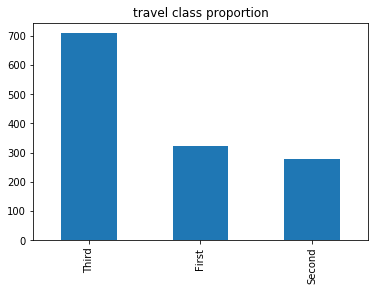

In [83]:
titanic.pclass.value_counts().plot(kind='bar')
plt.title('travel class proportion')

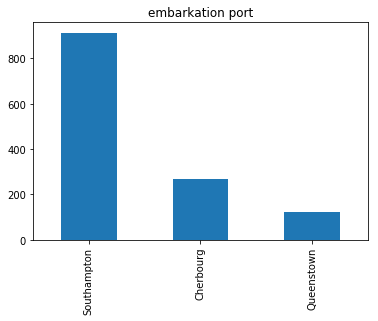

In [84]:
titanic.embarked.value_counts().plot(kind='bar')
plt.title('embarkation port')

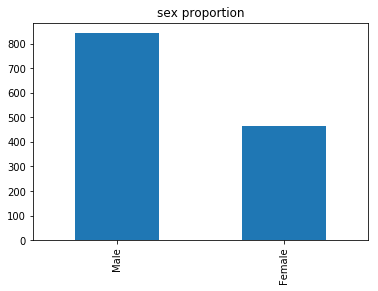

In [85]:
titanic.sex.value_counts().plot(kind='bar')
plt.title('sex proportion')

For this histogram we use discrete decade intervals from 0 to 80 (maximum age)

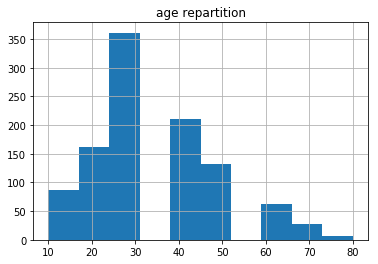

In [86]:
pd.cut(titanic.age, [0, 10, 20, 30, 40, 50, 60, 70, 80], labels=[10, 20, 30, 40, 50, 60, 70, 80]).hist()
plt.title('age repartition')

### Question 3

We are looking for the proportion of passengers by cabin floor. We thus copy the cabin attribute to drop the NAN without altering the original one. We copy/modify it in a way such that we just keep the letter of the cabin floor.

In [87]:
floor_counts = titanic.cabin.copy()\
                            .str.extract('([A-Z])')\
                            .dropna()\
                            .value_counts()

/home/thomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


We then present the results in a pie chart with the different letters of the cabin floors

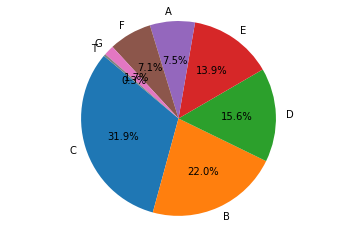

In [88]:
plt.pie(floor_counts, labels=floor_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

### Question 4

In this question we will present our results in three pie charts : one for each travel class representing the proportion of the passengers that survived.

So first of all we group the entries by pclass and compute for each pclass the mean of survived people. Which gives us the proportion if survived passengers

In [89]:
survived = titanic[['pclass', 'survived']].groupby('pclass')\
                                          .mean()

In [90]:
survived

,survived
pclass,
First,0.619195
Second,0.429603
Third,0.255289


We know plot a pie chart for each class

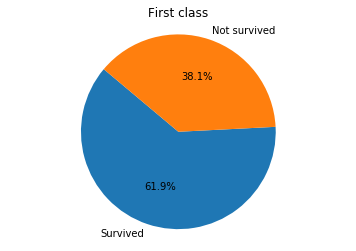

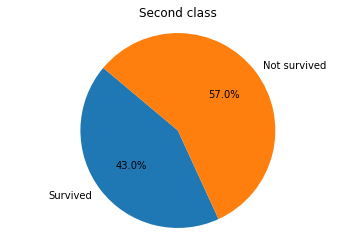

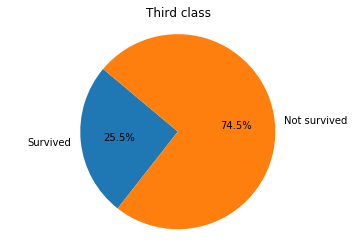

In [91]:
labels = 'Survived', 'Not survived'

for class_ in titanic.pclass.cat.categories:
    ratios = survived['survived'][class_], 1 - survived['survived'][class_]
    plt.pie(ratios, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')
    plt.title(' '.join([class_, 'class']))
    plt.show()

### Question 5

Here we want to represent the proportion of passengers that survived by travel class and sex.
To implement it we set the index (a multi index) of the titanic dataframe to (pclass, sex).
Thus we will be able to represent the "survival rate" in function of this index by grouping pclass and sex and applying the mean to the survived column

In [92]:
survival_rates_class_sex = titanic.set_index(['pclass','sex'])\
                                  .groupby(level=('pclass','sex'),axis=0)[['survived']]\
                                  .mean()

In [93]:
survival_rates_class_sex

survived
pclass sex             
First  Female  0.965278
       Male    0.340782
Second Female  0.886792
       Male    0.146199
Third  Female  0.490741
       Male    0.152130

We know represent our results in a single histogram

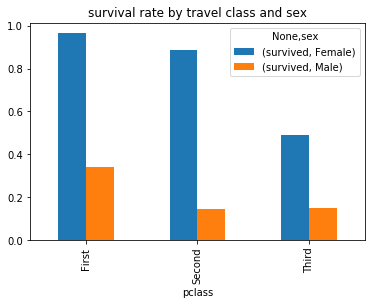

In [94]:
survival_rates_class_sex.unstack().plot.bar()
plt.title('survival rate by travel class and sex')

### Question 6

In this question we will work on ages. We first decide to drop all the NaN in the column of ages. Then we will create the two categories of ages

In [95]:
titanic2 = titanic.dropna(subset=['age']).copy()

To create the two age categories, we decide to use the median of all the ages which seems to be the best way of dividing the set. Hence we create the two categories "young" and "old" containing respectively the values [0, median] and [median+1, max]

In [96]:
titanic_ages = pd.cut(titanic.age, [0, titanic2.age.median(), titanic2.age.max()], labels=['young','old'])
titanic2['age'] = titanic_ages

We now groupby the dataframe with pclass, sex and age as they are the attributes we are interested in and compute the mean of 'survived' values for those groups.

In [97]:
result = titanic2.groupby(('pclass','sex','age'),axis=0)[['survived']]\
                 .mean()\
                 .round(3)\
                 .unstack('age')

In [98]:
result

survived       
age              young    old
pclass sex                   
First  Female    0.951  0.967
       Male      0.531  0.303
Second Female    0.911  0.872
       Male      0.216  0.083
Third  Female    0.514  0.372
       Male      0.183  0.144

We now check that the index of our dataframe is unique

In [99]:
result.index.is_unique

True